In [ ]:
!pip freeze --user | grep -v '@' | xargs pip uninstall -y

!rm -rf spex
!git clone https://github.com/zverozabr/spex.git spex

In [ ]:
!pip install --no-cache-dir --use-pep517 ./spex

In [2]:
import os
import glob
import numpy as np
from skimage import segmentation
from tifffile import TiffWriter, TiffFile

import spex as sp

img='TA459_multipleCores2_Run-4_Point1.tiff'

Image, channel=sp.load_image(img)

print("Image loaded with the following",len(channel),"channels:",channel)

2025-05-10 03:33:51.550749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 03:33:51.614742: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 03:33:51.617526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-10 03:33:51.617534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

Image loaded with the following 44 channels: ['Au', 'Background', 'Beta catenin', 'Ca', 'CD11b', 'CD11c', 'CD138', 'CD16', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8', 'dsDNA', 'EGFR', 'Fe', 'FoxP3', 'H3K27me3', 'H3K9ac', 'HLA-DR', 'HLA_Class_1', 'IDO', 'Keratin17', 'Keratin6', 'Ki67', 'Lag3', 'MPO', 'Na', 'P', 'p53', 'Pan-Keratin', 'PD-L1', 'PD1', 'phospho-S6', 'Si', 'SMA', 'Ta', 'Vimentin']


 Step 1: Load image and extract channels as a list
(or use OMERO api to pull tiff image and channel names)

In [25]:
index=channel.index('Au')
bgcorrect_Image=sp.background_subtract(Image, index, 10,2)

index=channel.index('Background')
bgcorrect_Image=sp.background_subtract(bgcorrect_Image, index, 10,2)

fromnumeric.py (3432): Mean of empty slice.
_methods.py (190): invalid value encountered in double_scalars


OPTIONAL - NLM Denoising


In [26]:
nlm_Image =sp.nlm_denoise(bgcorrect_Image,5,6)

OPTIONAL - Median filter

In [27]:
list=['dsDNA','H3K9ac','H3K27me3']

to_denoise=[]
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_denoise.append(index)
to_denoise.sort()

median_Image=sp.median_denoise(Image,4,to_denoise)

Step 3: Cell Segmentation
User will select 1 of the 3 segmentation options. Output will be a label image where each cell is assigned an integer value.
 StarDist deep learning segmentation

In [28]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

stardist_label=sp.stardist_cellseg(median_Image, to_merge, 1, 0.5, 1, 98.5)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-05-09 02:32:16.204993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/spex/.local/lib/python3.10/site-packages/cv2/../../lib64:
2025-05-09 02:32:16.205006: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-09 02:32:16.205015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spex): /proc/driver/nvidia/version does not exist
2025-05-09 02:32:16.205122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


OR Cellpose deep learning segmentation


In [29]:

list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

cellpose_label=sp.cellpose_cellseg(median_Image, to_merge,12, 1)

09-May-25 02:32:20 - cellpose.core - INFO     - >>>> using CPU
09-May-25 02:32:20 - cellpose.models - INFO     - ~~~ FINDING MASKS ~~~
09-May-25 02:34:10 - cellpose.models - INFO     - >>>> TOTAL TIME 110.17 sec


OR Classic watershed segmentation


In [48]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

classic_label=sp.watershed_classic(median_Image, to_merge)

Step 3a: Visualization and saving of segmentation results


In [49]:
import sys
!{sys.executable} -m pip install pyparsing matplotlib
from tifffile import imwrite, imsave
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage.segmentation import expand_labels,mark_boundaries

09-May-25 03:02:20 - matplotlib.image - WARNING  - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


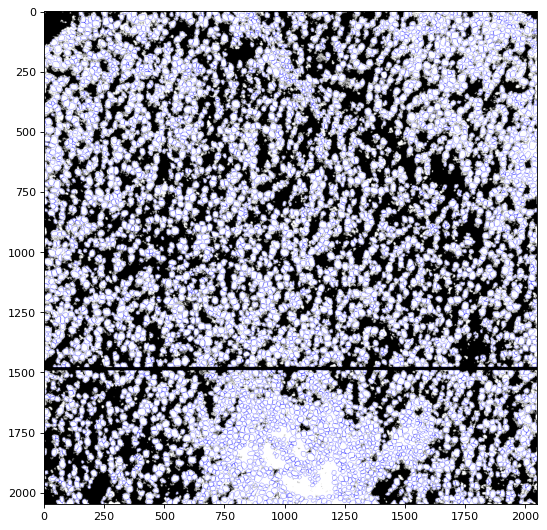

In [50]:

nuc=np.zeros((Image.shape[1],Image.shape[2]))
for i in to_merge:
    temp=Image[i]
    nuc=temp+nuc

#save full resolution grayscale image of segmentation
imwrite(img.split('.')[0]+'_segmentationlabels.tif', stardist_label, photometric='minisblack')

#save low res image
figure(figsize=(8, 8), dpi=80)
boundary=mark_boundaries(np.squeeze(nuc), stardist_label,(0, 0, 255)).astype('uint8')
plt.imsave(img.split('.')[0]+'_segmentation.jpg',boundary)

plt.imshow(mark_boundaries(np.squeeze(nuc), stardist_label,(0, 0, 255)))

 Step 4: Postprocessing
These modules are optional. User will select what functions they want to chain together
 Rescue cells missed by DL model. (uses traditional watershed) - This is an optional step to add after segmentatio step.

In [51]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

new_label=sp.rescue_cells(Image,to_merge, stardist_label)

postprocessing.py (74): indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


Remove small and/or large segments


In [52]:
newlabel=sp.remove_small_objects(new_label, 8)
newlabel=sp.remove_large_objects(new_label, 75)

In [53]:
expanded_label=sp.simulate_cell(stardist_label, 10)

In [54]:
anndata=sp.feature_extraction_adata(Image, expanded_label,channel)

df = anndata.to_df()
df['centroid-0'] = anndata.obs['y_coordinate'].values
df['centroid-1'] = anndata.obs['x_coordinate'].values
df

anndata.py (121): Transforming to str index.


,Au,Background,Beta catenin,Ca,CD11b,CD11c,CD138,CD16,CD20,CD209,...,Pan-Keratin,PD-L1,PD1,phospho-S6,Si,SMA,Ta,Vimentin,centroid-0,centroid-1
0,2.713917,0.131443,0.0,3.935567,0.000000,0.000000,0.466495,0.000000,0.373711,0.0,...,0.806701,0.0,0.0,0.521907,0.452320,0.068299,1.157217,0.0,195.573454,1960.447165
1,0.595855,0.089119,0.0,1.675648,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.563731,0.0,0.0,0.218653,0.366839,0.000000,0.214508,0.0,1714.545078,117.876684
2,1.520742,0.061135,0.0,1.740175,0.000000,0.000000,0.216157,0.000000,0.537118,0.0,...,0.203057,0.0,0.0,0.208515,0.394105,0.000000,1.163755,0.0,1819.518559,716.461790
3,1.791539,0.074188,0.0,2.496015,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.182097,0.0,0.0,0.147149,0.442060,0.000000,0.870632,0.0,1005.256284,997.931944
4,3.860111,0.096953,0.0,4.918283,0.000000,0.000000,0.004155,0.000000,0.000000,0.0,...,0.105263,0.0,0.0,0.644044,0.445983,0.630194,3.072022,0.0,741.481994,1340.619114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106,4.980159,0.079365,0.0,1.726190,0.031746,0.158730,0.000000,0.371032,0.680556,0.0,...,0.099206,0.0,0.0,0.924603,0.398810,0.000000,4.888889,0.0,276.051587,798.587302
5107,1.577114,0.044776,0.0,1.905473,0.000000,0.248756,0.000000,0.000000,0.000000,0.0,...,0.002488,0.0,0.0,0.365672,6.763681,0.017413,0.335821,0.0,801.557214,1346.694030
5108,9.111111,0.066066,0.0,2.135135,0.000000,0.000000,0.000000,0.000000,0.111111,0.0,...,0.177177,0.0,0.0,0.204204,0.372372,0.000000,13.372373,0.0,864.042042,124.561562
5109,0.373887,0.062315,0.0,2.005935,0.000000,0.000000,0.000000,0.000000,1.436202,0.0,...,0.000000,0.0,0.0,0.320475,0.317507,0.000000,0.097923,0.0,2034.231454,1265.569733


In [55]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


AnnData object with n_obs × n_vars = 5111 × 44
    obs: 'Cell_ID', 'Nucleus_area', 'x_coordinate', 'y_coordinate'
    obsm: 'spatial', 'cell_polygon'
    layers: 'X_uint8'

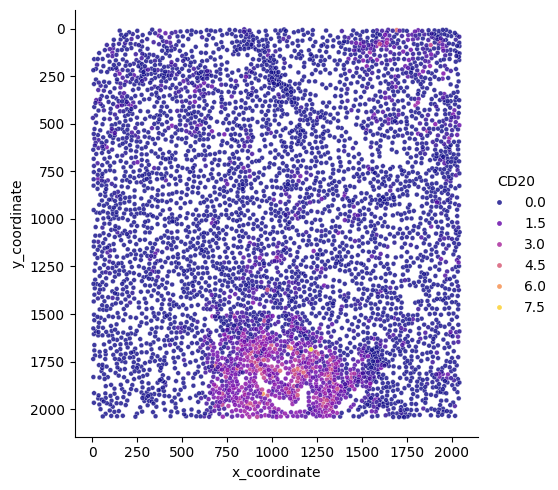

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# add coor
df[['x_coordinate', 'y_coordinate']] = anndata.obs[['x_coordinate', 'y_coordinate']]

# Визуализация
g = sns.relplot(
    data=df,
    x='x_coordinate',
    y='y_coordinate',
    hue='CD20',
    palette='plasma',
    s=12,
    alpha=0.8
)

g.facet_axis(0, 0).invert_yaxis()
anndata

In [57]:
!pip install "scanpy<1.10"

Defaulting to user installation because normal site-packages is not writeable


In [62]:

import anndata as ad
from anndata import AnnData
import scanpy as sc
from scipy.stats import zscore
import pandas as pd

In [63]:
print(df.columns)
coordinates=[]
for k in range(0,len(df),1):
    coordinates.append([df.loc[df.index[k],'centroid-1'],df.loc[df.index[k],'centroid-0']])

coordinates=np.array(coordinates)
coordinates

# format labels.
celltype = pd.DataFrame({'label': anndata.obs['Cell_ID'].astype(str)})
celltype['label'] = celltype['label'].astype('category')
celltype = celltype.rename(columns={'label': 'Cell_ID'})

# expression data
expression_data=df[channel]

# package in anndata object
adata = AnnData(expression_data, obsm={"spatial": coordinates})
adata.obs['Cell_ID'] = [str(i) for i in celltype['Cell_ID'].tolist()]
adata.layers["zscored"] = expression_data.apply(zscore)

adata.write(img.split('.')[0]+'.h5ad', compression="gzip") # save data to disk as anndata object

adata

Index(['Au', 'Background', 'Beta catenin', 'Ca', 'CD11b', 'CD11c', 'CD138',
       'CD16', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56',
       'CD63', 'CD68', 'CD8', 'dsDNA', 'EGFR', 'Fe', 'FoxP3', 'H3K27me3',
       'H3K9ac', 'HLA-DR', 'HLA_Class_1', 'IDO', 'Keratin17', 'Keratin6',
       'Ki67', 'Lag3', 'MPO', 'Na', 'P', 'p53', 'Pan-Keratin', 'PD-L1', 'PD1',
       'phospho-S6', 'Si', 'SMA', 'Ta', 'Vimentin', 'centroid-0', 'centroid-1',
       'x_coordinate', 'y_coordinate'],
      dtype='object')


AnnData object with n_obs × n_vars = 5111 × 44
    obs: 'Cell_ID'
    obsm: 'spatial'
    layers: 'zscored'

Similar process for phenotyping/clustering results


In [64]:
df['cluster_id'] = np.random.randint(1, 6, df.shape[0]) # create random example cluster ids

# format cluster ids into anndata
cluster=df[['cluster_id']]
cluster['cluster_id'] = cluster.cluster_id.astype('category')

#adata.obs['cluster_id'] = cluster['cluster_id'].tolist()  #add cluster to adata object
adata.obs['cluster_id'] = [str(i) for i in cluster['cluster_id'].tolist()]

adata.write(img.split('.')[0]+'.h5ad', compression="gzip") # save data to disk as anndata object

adata

1638989555.py (5): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AnnData object with n_obs × n_vars = 5111 × 44
    obs: 'Cell_ID', 'cluster_id'
    obsm: 'spatial'
    layers: 'zscored'

Phenotyping plotting


In [65]:
import scanpy as sc

_matrixplot.py (143): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
_dendrogram.py (135): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


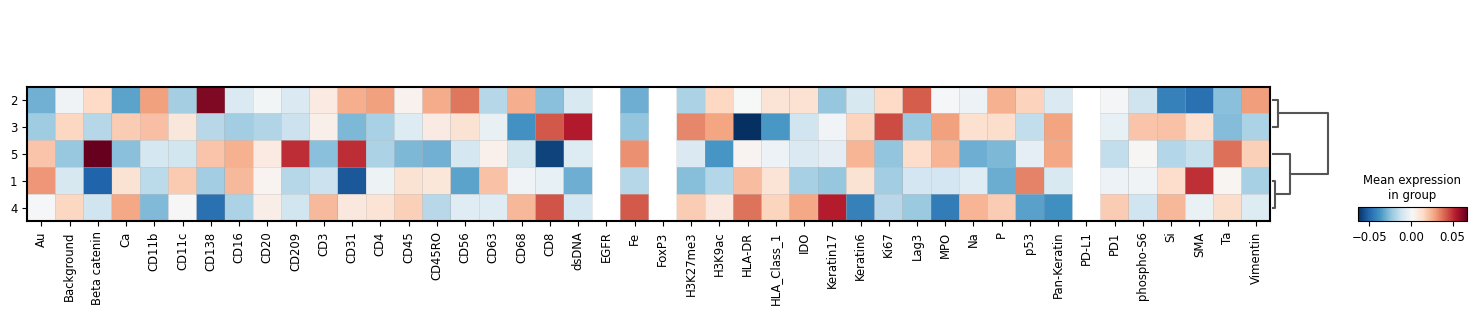

In [66]:
var_names=adata.to_df().columns.tolist()
sc.pl.matrixplot(adata, var_names, 'cluster_id', dendrogram=True, cmap='RdBu_r',layer='zscored')

_anndata.py (839): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

_anndata.py (839): 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
_anndata.py (839): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

_anndata.py (839): 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
_anndata.py (839): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

_anndata.py (839): 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.


[<Axes: ylabel='CD20'>, <Axes: ylabel='CD3'>, <Axes: ylabel='CD4'>]

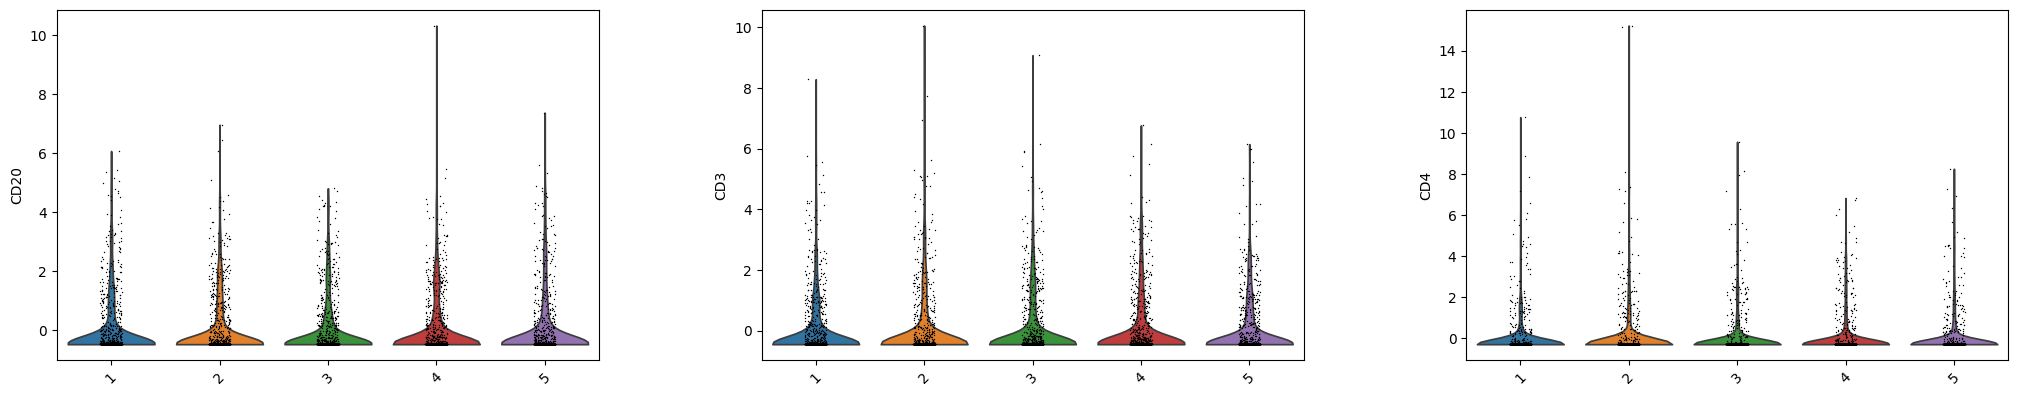

In [67]:
markerlist=['CD20','CD3','CD4'] #user selection

sc.pl.violin(adata, markerlist, groupby='cluster_id', rotation=45, show=False,layer='zscored')

 ## Example Batch Process
Running a folder of images through the SPEX pipeline

In [3]:
files = glob.glob('*.tiff', recursive = False)
files

['TA459_multipleCores2_Run-4_Point1.tiff']

In [9]:
import os


for image in files:
    #Load Image
    Image, channel=sp.load_image(image)
    print(channel)

    #Denoise Image
    list=['dsDNA','H3K9ac','H3K27me3']

    to_denoise=[]
    for i in range(0,len(list),1):
        index=channel.index(list[i])
        to_denoise.append(index)
    to_denoise.sort()

    median_Image=sp.median_denoise(Image,5,to_denoise)

    #Run Segmentation
    list=['dsDNA','H3K9ac','H3K27me3']

    to_merge=[]
    for i in range(0,len(list),1):
        index=channel.index(list[i])
        to_merge.append(index)
    to_merge.sort()

    stardist_label=sp.stardist_cellseg(median_Image, to_merge, 1, 0.5, 1, 98.5)
    cellpose_label=sp.cellpose_cellseg(median_Image, to_merge,12, 1)

    #index=channel.index('H3K27me3')
    new_label=sp.rescue_cells(Image,to_merge, stardist_label)
    new_label2=sp.rescue_cells(Image,to_merge, cellpose_label)
    #new_label3=sp.rescue_cells(Image,index, deepcell_label)

    #Dilate Cells
    expanded_label=sp.simulate_cell(new_label, 10)
    expanded_label2=sp.simulate_cell(new_label2, 10)

    #Extract Features
    #df=sp.feature_extraction(Image, expanded_label,channel)
    anndata=sp.feature_extraction_adata(Image, expanded_label,channel)

    df = anndata.to_df()
    df['centroid-0'] = anndata.obs['y_coordinate'].values
    df['centroid-1'] = anndata.obs['x_coordinate'].values
    df

    #Save Feature Data
    csvname = image.split(".tiff")[0]+'_stardist.csv'
    df.to_csv(csvname, index = False)

    #Save Image of segmentation
    imagename = image.split(".tiff")[0]+'_label.ome.tiff'

    contour=segmentation.find_boundaries(expanded_label, connectivity=1, mode='thick', background=0)
    contour2=segmentation.find_boundaries(expanded_label2, connectivity=1, mode='thick', background=0)
    pseudoIF=np.stack((Image[channel.index('dsDNA')],Image[channel.index('H3K9ac')],Image[channel.index('H3K27me3')],contour,contour2), axis=0)

    with TiffWriter(imagename, bigtiff=True) as tif:
        options = dict(tile=(512, 512),photometric='minisblack')
        tif.write(
            pseudoIF,
            **options,
            metadata={
                'PhysicalSizeX': 0.39,
                'PhysicalSizeY': 0.39,
                'Channel': {
                    'Name': ["dsDNA", "H3K9ac", "H3K27me3", "Stardist", "DeepCell"]
                }
            }
        )


['Au', 'Background', 'Beta catenin', 'Ca', 'CD11b', 'CD11c', 'CD138', 'CD16', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8', 'dsDNA', 'EGFR', 'Fe', 'FoxP3', 'H3K27me3', 'H3K9ac', 'HLA-DR', 'HLA_Class_1', 'IDO', 'Keratin17', 'Keratin6', 'Ki67', 'Lag3', 'MPO', 'Na', 'P', 'p53', 'Pan-Keratin', 'PD-L1', 'PD1', 'phospho-S6', 'Si', 'SMA', 'Ta', 'Vimentin']
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


10-May-25 04:06:44 - tensorflow - WARNING  - 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f05f84ef2e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
10-May-25 04:06:44 - cellpose.core - INFO     - >>>> using CPU
10-May-25 04:06:44 - cellpose.models - INFO     - ~~~ FINDING MASKS ~~~
10-May-25 04:08:37 - cellpose.models - INFO     - >>>> TOTAL TIME 112.76 sec
postprocessing.py (74): indices argument is deprecated and will 